In [ ]:
!pip install yfinance

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3781    0  3781    0     0   8896      0 --:--:-- --:--:-- --:--:--  8875
100  503k  100  503k    0     0   470k      0  0:00:01  0:00:01 --:--:--  470k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3809    0  3809    0     0   8316      0 --:--:-- --:--:-- --:--:--  8298
100  406k  100  406k    0     0   386k      0  0:00:01  0:00:01 --:--:--  386k


In [ ]:
import pandas as pd 
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf

데이터 전처리

In [ ]:
df = yf.download('INTC',start='2000-01-01')
sox_df = yf.download('^SOX',start='2000-01-01')
vix_df = yf.download('^VIX',start='2000-01-01')
snp500_df = yf.download('^GSPC',start='2000-01-01')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
df['next_price'] = df['Adj Close'].shift(-1)
df['next_rtn'] = df['Close'] / df['Open'] -1
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

#1.RA : Standard deviation rolling average
# Moving Average
df['MA5'] = talib.SMA(df['Close'],timeperiod=5)
df['MA10'] = talib.SMA(df['Close'],timeperiod=10)
df['RASD5'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=5)
df['RASD10'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=10)

#2.MACD : Moving Average Convergence/Divergence
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd 

# Momentum Indicators
#3.CCI : Commodity Channel Index
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)
# Volatility Indicators 

#4.ATR : Average True Range
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

#5.BOLL : Bollinger Band
upper, middle, lower = talib.BBANDS(df['Close'],timeperiod=20,nbdevup=2,nbdevdn=2,matype=0)
df['ub'] = upper
df['middle'] = middle
df['lb'] = lower

#7.MTM1 
df['MTM1'] = talib.MOM(df['Close'], timeperiod=1)

#7.MTM3
df['MTM3'] = talib.MOM(df['Close'], timeperiod=3)

#8.ROC : Rate of change : ((price/prevPrice)-1)*100
df['ROC'] = talib.ROC(df['Close'], timeperiod=60)

#9.WPR : william percent range (Williams' %R)
df['WPR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

In [ ]:
snp500_df = snp500_df.loc[:,['Close']].copy()
snp500_df.rename(columns={'Close':'S&P500'},inplace=True)
sox_df = sox_df.loc[:,['Close']].copy()
sox_df.rename(columns={'Close':'SOX'},inplace=True)
vix_df = vix_df.loc[:,['Close']].copy()
vix_df.rename(columns={'Close':'VIX'},inplace=True)

df = df.join(snp500_df,how='left')
df = df.join(sox_df,how='left')
df = df.join(vix_df,how='left')

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,next_price,next_rtn,log_return,CCI,MA5,MA10,RASD5,RASD10,MACD,ATR,ub,middle,lb,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,41.632812,43.6875,41.62500,43.50000,26.643175,57710200,25.399075,0.044849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1455.219971,713.200012,24.209999
2000-01-04,42.718750,43.9375,41.12500,41.46875,25.399075,51019600,25.609608,-0.029261,-0.047820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.03125,NaN,NaN,NaN,1399.420044,687.320007,27.010000
2000-01-05,41.500000,42.9375,40.25000,41.81250,25.609608,52389000,24.116674,0.007530,0.008255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34375,NaN,NaN,NaN,1402.109985,678.539978,26.410000
2000-01-06,40.875000,41.6875,39.09375,39.37500,24.116674,55171200,25.111965,-0.036697,-0.060064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.43750,-4.12500,NaN,NaN,1403.449951,669.330017,25.730000
2000-01-07,38.750000,41.0000,38.68750,41.00000,25.111965,41096400,26.260382,0.058065,0.040441,NaN,41.43125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.62500,-0.46875,NaN,NaN,1441.469971,690.750000,21.719999


In [ ]:
# feature list
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return']
feature2_list = ['RASD5','RASD10','ub','lb','CCI','ATR','MACD','MA5','MA10','MTM1','MTM3','ROC','WPR']
feature3_list = ['S&P500', 'SOX', 'VIX']
feature4_list = ['next_rtn']

all_features = feature1_list + feature2_list + feature3_list + feature4_list

In [ ]:
phase_flag = '3'

if phase_flag == '1' :
    train_from = '2010-01-04'
    train_to = '2012-01-01'

    val_from = '2012-01-01'
    val_to = '2012-04-01'

    test_from = '2012-04-01'
    test_to = '2012-07-01'

elif phase_flag == '2' :
    train_from = '2012-07-01'
    train_to = '2014-07-01'

    val_from = '2014-07-01'
    val_to = '2014-10-01'

    test_from = '2014-10-01'
    test_to = '2015-01-01'
    
else : 
    train_from = '2015-01-01'
    train_to = '2017-01-01'

    val_from = '2017-01-01'
    val_to = '2017-04-01'

    test_from = '2017-04-01'
    test_to = '2017-07-01'

In [ ]:
# train / validation / testing
train_df  = df.loc[train_from:train_to,all_features].copy()
val_df = df.loc[val_from:val_to,all_features].copy()
test_df   = df.loc[test_from:test_to,all_features].copy()

In [ ]:
train_df

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,CCI,ATR,MACD,MA5,MA10,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX,next_rtn
Date,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,36.669998,37.160000,36.110001,30.078136,23605600,0.001927,0.360369,0.422398,37.964195,35.625804,-31.453150,0.695825,0.303488,36.828,36.961,0.070000,-0.820000,8.634596,-57.261459,2058.199951,686.729980,17.790001,-0.008454
2015-01-05,36.200001,36.450001,35.939999,29.738970,32785000,-0.011340,0.359143,0.416504,37.902114,35.536885,-87.370255,0.682552,0.216350,36.508,36.854,-0.410000,-0.809998,4.902248,-74.273902,2020.579956,673.590027,19.920000,-0.006906
2015-01-06,36.080002,36.230000,35.259998,29.184723,30847600,-0.018813,0.429746,0.417354,37.855069,35.344930,-141.831811,0.703084,0.092167,36.128,36.745,-0.670002,-1.010002,4.937537,-99.193531,2002.609985,658.830017,21.120001,-0.022173
2015-01-07,35.639999,36.070000,35.270000,29.796881,27725200,0.020758,0.449678,0.396641,37.788620,35.293380,-114.324726,0.710006,0.052853,35.980,36.626,0.740002,-0.340000,12.879977,-69.354794,2025.900024,665.270020,19.309999,0.010662
2015-01-08,36.369999,37.000000,36.259998,30.351124,31765400,0.018430,0.450896,0.396890,37.770449,35.291550,-11.701877,0.729292,0.074897,36.060,36.552,0.669998,0.739998,16.587224,-42.338775,2062.139893,684.650024,17.010000,0.008798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,36.930000,36.980000,36.770000,32.542244,6287300,0.001083,0.244873,0.329310,37.926178,33.764822,62.780313,0.560067,0.509294,36.996,36.740,0.040001,-0.239998,-0.937831,-12.458929,2263.790039,927.919983,11.440000,0.001083
2016-12-27,36.910000,37.330002,36.910000,32.630264,9033700,0.002701,0.222587,0.296135,38.064119,33.782881,81.718745,0.550063,0.516050,37.032,36.850,0.099998,0.090000,-1.801325,-9.655138,2268.879883,939.210022,11.990000,0.004335
2016-12-28,37.099998,37.200001,36.580002,32.242958,12868600,-0.011941,0.191533,0.265896,38.131784,33.847216,34.188064,0.555058,0.480363,36.916,36.833,-0.439999,-0.299999,-2.734994,-33.802739,2249.919922,921.090027,12.950000,-0.012668


In [ ]:
def min_max_normal(tmp_df):
    eng_list = []
    sample_df = tmp_df.copy()
    for x in all_features:
        if x in feature4_list :
            continue
        series = sample_df[x].copy()
        values = series.values
        values = values.reshape((len(values), 1))
        # train the normalization
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = scaler.fit(values)
        print('columns : %s , Min: %f, Max: %f' % (x, scaler.data_min_, scaler.data_max_))
        # normalize the dataset and print
        normalized = scaler.transform(values)
        new_feature = '{}_normal'.format(x)
        eng_list.append(new_feature)
        sample_df[new_feature] = normalized
    return sample_df, eng_list

In [ ]:
train_sample_df, eng_list =  min_max_normal(train_df)
val_sample_df, eng_list =  min_max_normal(val_df)
test_sample_df, eng_list = min_max_normal(test_df)

columns : Open , Min: 25.200001, Max: 38.250000
columns : High , Min: 27.150000, Max: 38.360001
columns : Low , Min: 24.870001, Max: 37.900002
columns : Adj Close , Min: 21.890184, Max: 33.284885
columns : Volume , Min: 5893800.000000, Max: 107402400.000000
columns : log_return , Min: -0.095433, Max: 0.061875
columns : RASD5 , Min: 0.074538, Max: 1.083140
columns : RASD10 , Min: 0.097033, Max: 0.915689
columns : ub , Min: 29.594536, Max: 39.179495
columns : lb , Min: 26.053708, Max: 36.736935
columns : CCI , Min: -315.499106, Max: 287.225643
columns : ATR , Min: 0.416201, Max: 0.985690
columns : MACD , Min: -1.220378, Max: 1.270802
columns : MA5 , Min: 26.702000, Max: 37.944000
columns : MA10 , Min: 27.437000, Max: 37.716000
columns : MTM1 , Min: -2.980001, Max: 1.920000
columns : MTM3 , Min: -3.150002, Max: 2.549999
columns : ROC , Min: -23.824722, Max: 28.179354
columns : WPR , Min: -100.000000, Max: -0.000000
columns : S&P500 , Min: 1829.079956, Max: 2271.719971
columns : SOX , Min:

In [ ]:
train_sample_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,CCI,ATR,MACD,MA5,MA10,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX,next_rtn,Open_normal,High_normal,Low_normal,Adj Close_normal,Volume_normal,log_return_normal,RASD5_normal,RASD10_normal,ub_normal,lb_normal,CCI_normal,ATR_normal,MACD_normal,MA5_normal,MA10_normal,MTM1_normal,MTM3_normal,ROC_normal,WPR_normal,S&P500_normal,SOX_normal,VIX_normal
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,36.669998,37.160000,36.110001,30.078136,23605600,0.001927,0.360369,0.422398,37.964195,35.625804,-31.453150,0.695825,0.303488,36.828,36.961,0.070000,-0.820000,8.634596,-57.261459,2058.199951,686.729980,17.790001,-0.008454,0.878927,0.892953,0.862625,0.718575,0.174486,0.618912,0.283393,0.397438,0.873208,0.895993,0.471270,0.491009,0.611705,0.900729,0.926549,0.622449,0.408772,0.624169,0.427385,0.517622,0.335631,0.221242
2015-01-05,36.200001,36.450001,35.939999,29.738970,32785000,-0.011340,0.359143,0.416504,37.902114,35.536885,-87.370255,0.682552,0.216350,36.508,36.854,-0.410000,-0.809998,4.902248,-74.273902,2020.579956,673.590027,19.920000,-0.006906,0.842912,0.829616,0.849578,0.688810,0.264915,0.534572,0.282178,0.390239,0.866731,0.887670,0.378496,0.467702,0.576726,0.872265,0.916140,0.524490,0.410527,0.552398,0.257261,0.432631,0.301055,0.293519
2015-01-06,36.080002,36.230000,35.259998,29.184723,30847600,-0.018813,0.429746,0.417354,37.855069,35.344930,-141.831811,0.703084,0.092167,36.128,36.745,-0.670002,-1.010002,4.937537,-99.193531,2002.609985,658.830017,21.120001,-0.022173,0.833717,0.809991,0.797390,0.640169,0.245829,0.487068,0.352179,0.391277,0.861823,0.869702,0.288137,0.503756,0.526877,0.838463,0.905536,0.471428,0.375438,0.553077,0.008065,0.392034,0.262216,0.334238
2015-01-07,35.639999,36.070000,35.270000,29.796881,27725200,0.020758,0.449678,0.396641,37.788620,35.293380,-114.324726,0.710006,0.052853,35.980,36.626,0.740002,-0.340000,12.879977,-69.354794,2025.900024,665.270020,19.309999,0.010662,0.800000,0.795718,0.798158,0.693892,0.215069,0.738621,0.371941,0.365975,0.854890,0.864876,0.333775,0.515911,0.511096,0.825298,0.893959,0.759184,0.492983,0.705804,0.306452,0.444650,0.279162,0.272820
2015-01-08,36.369999,37.000000,36.259998,30.351124,31765400,0.018430,0.450896,0.396890,37.770449,35.291550,-11.701877,0.729292,0.074897,36.060,36.552,0.669998,0.739998,16.587224,-42.338775,2062.139893,684.650024,17.010000,0.008798,0.855939,0.878680,0.874136,0.742533,0.254871,0.723819,0.373148,0.366279,0.852994,0.864705,0.504040,0.549775,0.519944,0.832414,0.886759,0.744898,0.682456,0.777092,0.576612,0.526523,0.330158,0.194774


훈련데이터 구분

In [ ]:
num_step = 5
num_unit = 200

In [ ]:
def create_dateset_binary(data, feature_list, step, n):
    '''
    다음날 시종가 수익률 라벨링.
    '''
    train_xdata = np.array(data[feature_list[0:n]])#모델에 넣어 줄 변수데이터 선택
    
    # 가장 뒤 n step을 제외하기 위해. 왜냐하면 학습 input으로는 어차피 10개만 주려고 하니깐.
    m = np.arange(len(train_xdata) - step)
    x, y = [], []
    for i in m:
        a = train_xdata[i:(i+step)]#각 단계마다 학습할 데이터기간을 얼마나 입력할지
        x.append(a)
    x_batch = np.reshape(np.array(x), (len(m), step, n))
    '''
    len(m): 한 칸씩 미뤘을 때 최대한 만들 수 있는 인풋데이터 갯수(batch size)
    step: 행의 수
    n: 열의 수
    '''
    train_ydata = np.array(data[[feature_list[n]]])#레이블링데이터(종가)
    # n_step 이상부터 답을 사용할 수 있는거니깐. 
    for i in m + step :
        next_rtn = train_ydata[i][0]
        if next_rtn > 0 :
            label = 1
        else :
            label = 0
        y.append(label)
    y_batch = np.reshape(np.array(y), (-1,1))#학습을 위해 벡터화
    return x_batch, y_batch

In [ ]:
eng_list = eng_list + feature4_list
n_feature = len(eng_list)-1

x_train, y_train = create_dateset_binary(train_sample_df[eng_list], eng_list, num_step, n_feature)
x_val, y_val = create_dateset_binary(val_sample_df[eng_list], eng_list, num_step, n_feature)
x_test, y_test = create_dateset_binary(test_sample_df[eng_list], eng_list, num_step, n_feature)

In [ ]:
x_train.shape
#1개의 시점에서 22개의 변수 사용, 5일 데이터로 1step 학습(다음날 종가 예측), 1일 씩 총 499번 이동

(499, 5, 22)

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [ ]:
print(pd.DataFrame(y_train).sum())
print(pd.DataFrame(y_val).sum())
print(pd.DataFrame(y_test).sum())

0    229.0
1    270.0
dtype: float32
0    29.0
1    28.0
dtype: float32
0    31.0
1    27.0
dtype: float32


모델 구조

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

In [ ]:
# LSTM 모델을 생성한다.
K.clear_session()
#입력 데이터셋 형태에 맞게 값 지정, None은 모든 임의의 스칼라(어떤 값이든), 시간 축, 한번에 입력되는 데이터 갯수(feature)
input_layer = Input(batch_shape=(None, x_train.shape[1], x_train.shape[2]))
#다층 구조(5개), 마지막 층에선 return_sequences제거, 계속해서 callback임, 각 층에 L2규제함.
layer_lstm_1 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(input_layer)
#배치정규화해서 층 이어주기
layer_lstm_1 = BatchNormalization()(layer_lstm_1)
layer_lstm_2 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_1)
#드랍아웃층을 이어 임의의 확률로 가중치 선 지우기(overfitting방지)
#LSTM층->BatchNormalize->LSTM->Dropout 반복
layer_lstm_2 = Dropout(0.25)(layer_lstm_2)
layer_lstm_3 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)
layer_lstm_4 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_3)
layer_lstm_4 = Dropout(0.25)(layer_lstm_4)
layer_lstm_5 = LSTM(num_unit , recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5)
#완전 연결층으로 연결되면서 최종 예측값 뽑기
output_layer = Dense(2, activation='sigmoid')(layer_lstm_5)

model = Model(input_layer, output_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 22)]           0         
                                                                 
 lstm (LSTM)                 (None, 5, 200)            178400    
                                                                 
 batch_normalization (BatchN  (None, 5, 200)           800       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 5, 200)            320800    
                                                                 
 dropout (Dropout)           (None, 5, 200)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 200)            320800    
                                                             

In [ ]:
y_val.shape

(57, 2)

In [ ]:
#모델 학습
history = model.fit(x_train,y_train,epochs=20, batch_size=10, validation_data=(x_val, y_val))

Epoch 1/20
50/50 [==============================] - 14s 101ms/step - loss: 6.3524 - accuracy: 0.5271 - val_loss: 3.1243 - val_accuracy: 0.4912
Epoch 2/20
50/50 [==============================] - 3s 63ms/step - loss: 2.2789 - accuracy: 0.5110 - val_loss: 1.5497 - val_accuracy: 0.4912
Epoch 3/20
50/50 [==============================] - 3s 61ms/step - loss: 1.3288 - accuracy: 0.4970 - val_loss: 1.0696 - val_accuracy: 0.4912
Epoch 4/20
50/50 [==============================] - 3s 62ms/step - loss: 1.0239 - accuracy: 0.5090 - val_loss: 0.8778 - val_accuracy: 0.4912
Epoch 5/20
50/50 [==============================] - 3s 62ms/step - loss: 0.9111 - accuracy: 0.4770 - val_loss: 0.7921 - val_accuracy: 0.4912
Epoch 6/20
50/50 [==============================] - 3s 61ms/step - loss: 0.7939 - accuracy: 0.5551 - val_loss: 0.7535 - val_accuracy: 0.5263
Epoch 7/20
50/50 [==============================] - 3s 61ms/step - loss: 0.7804 - accuracy: 0.5511 - val_loss: 0.9106 - val_accuracy: 0.4386
Epoch 8/20


In [ ]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    plt.savefig('sample.png')

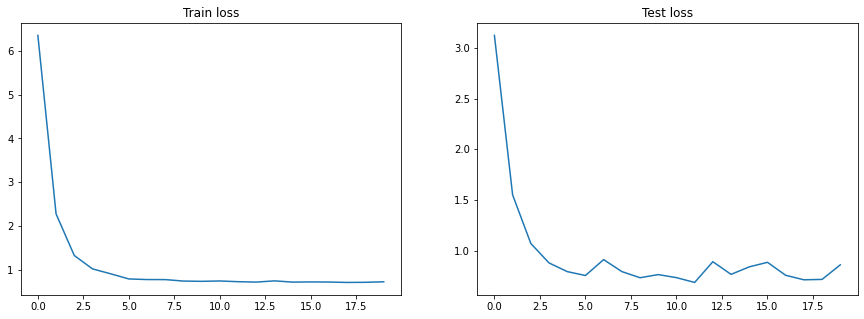

In [ ]:
plot_history(history)

예측

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
predicted = model.predict(x_test)
y_pred = np.argmax(predicted, axis=1)
Y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(Y_test, y_pred)
report = classification_report(Y_test, y_pred)

In [ ]:
y_pred # 3단계

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]
if tp == 0:
    tp = 1
if tn == 0:
    tn = 1
if fp == 0:
    fp = 1
if fn == 0:
    fn = 1
TPR = float(tp)/(float(tp)+float(fn))
FPR = float(fp)/(float(fp)+float(tn))
accuracy = round((float(tp) + float(tn))/(float(tp) +
                                          float(fp) + float(fn) + float(tn)), 3)
specitivity = round(float(tn)/(float(tn) + float(fp)), 3)
sensitivity = round(float(tp)/(float(tp) + float(fn)), 3)
mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/math.sqrt(
    (float(tp)+float(fp))
    * (float(tp)+float(fn))
    * (float(tn)+float(fp))
    * (float(tn)+float(fn))
), 3)

f_output = open('binary_lstm_open_close_phase3_dropout_batch_Normal_3단계 test.txt', 'a')
f_output.write('=======\n')
f_output.write('{}epochs_{}batch\n'.format(
    20, 10))
f_output.write('TN: {}\n'.format(tn))
f_output.write('FN: {}\n'.format(fn))
f_output.write('TP: {}\n'.format(tp))
f_output.write('FP: {}\n'.format(fp))
f_output.write('TPR: {}\n'.format(TPR))
f_output.write('FPR: {}\n'.format(FPR))
f_output.write('accuracy: {}\n'.format(accuracy))
f_output.write('specitivity: {}\n'.format(specitivity))
f_output.write("sensitivity : {}\n".format(sensitivity))
f_output.write("mcc : {}\n".format(mcc))
f_output.write("{}".format(report))
f_output.write('=======\n')
f_output.close()

ROC AUC 커브

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

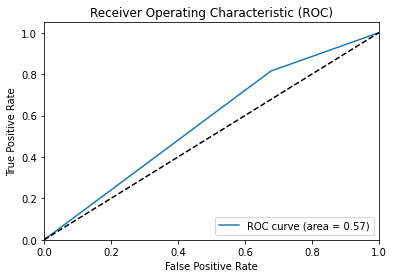

ROC AUC 값 : 0.5687


In [ ]:
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

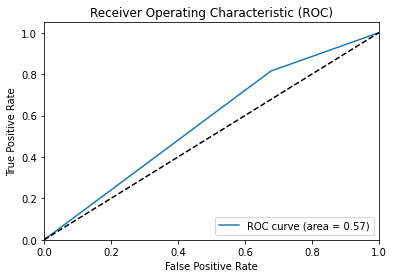

ROC AUC 값 : 0.5687


In [ ]:
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

Backtesting

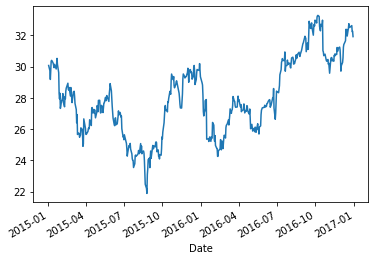

In [ ]:
train_sample_df['Adj Close'].plot()

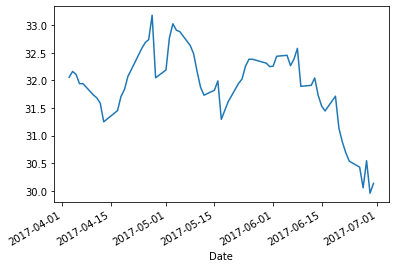

In [ ]:
test_sample_df['Adj Close'].plot()

In [ ]:
lstm_book_df = test_sample_df[['Adj Close','next_rtn']].copy()
t1 = pd.DataFrame(data = y_pred,columns=['position'],index = lstm_book_df.index[5:])
lstm_book_df = lstm_book_df.join(t1,how='left')
lstm_book_df.fillna(0,inplace=True)
lstm_book_df['ret'] = lstm_book_df['Adj Close'].pct_change()
lstm_book_df['lstm_ret'] = lstm_book_df['next_rtn'] * lstm_book_df['position'].shift(1)
lstm_book_df['lstm_cumret'] = (lstm_book_df['lstm_ret'] + 1).cumprod()
lstm_book_df['bm_cumret'] = (lstm_book_df['ret'] + 1).cumprod()

In [ ]:
lstm_book_df

,Adj Close,next_rtn,position,ret,lstm_ret,lstm_cumret,bm_cumret
Date,,,,,,,
2017-04-03,32.056488,-0.000829,0.0,NaN,NaN,NaN,NaN
2017-04-04,32.162868,0.004430,0.0,0.003319,0.0,1.000000,1.003319
2017-04-05,32.109680,-0.005764,0.0,-0.001654,-0.0,1.000000,1.001659
2017-04-06,31.941233,-0.002768,0.0,-0.005246,-0.0,1.000000,0.996405
2017-04-07,31.941233,-0.001109,0.0,0.000000,-0.0,1.000000,0.996405
...,...,...,...,...,...,...,...
2017-06-26,30.428356,-0.005546,0.0,-0.003510,-0.0,0.985874,0.949211
2017-06-27,30.053246,-0.010294,0.0,-0.012328,-0.0,0.985874,0.937509
2017-06-28,30.544453,0.012733,0.0,0.016345,0.0,0.985874,0.952832


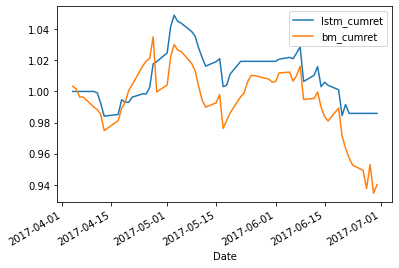

In [ ]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

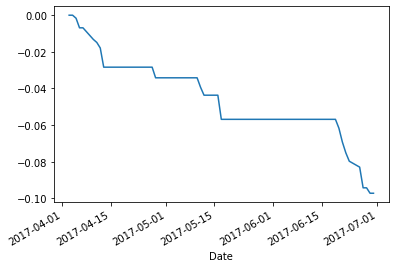

In [ ]:
historical_max = lstm_book_df['Adj Close'].cummax()
daily_drawdown = lstm_book_df['Adj Close'] / historical_max - 1.0
historical_dd = daily_drawdown.cummin()
historical_dd.plot()

In [ ]:
#Benchmark
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'bm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['ret']) / np.std(lstm_book_df['ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  -21.92 %
Sharpe :  -1.62
VOL :  14.82 %
MDD :  9.73 %


In [ ]:
#LSTM
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'lstm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['lstm_ret']) / np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  -5.53 %
Sharpe :  -0.52
VOL :  10.14 %
MDD :  9.73 %
